In [330]:
pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [331]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [332]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
from google.colab.patches import cv2_imshow

In [333]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [334]:
files = glob.glob('/content/data/*.jpg', 
                   recursive = True)


In [336]:
def img_processing(g_img):
  (thresh, img) = cv2.threshold(g_img, 127, 255, cv2.THRESH_BINARY)#chuyen ve dang nhi phan
  img = cv2.Canny(img,170,200)
  img_close = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))) #ap dung closing
  img_close = cv2.normalize(img_close, img_close, 0, 255, cv2.NORM_MINMAX) #chuan hoa hinh anh
  return img_close

In [337]:
def find_lin(img_close):
  contours, new  = cv2.findContours(img_close.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)#tim cac duong vien trong anh,
  contours=sorted(contours, key = cv2.contourArea, reverse = True)[:30]#sap xep lai theo thu tu giam dan lay 10 duong vien lon nhat
  contour_with_license_plate = None
  license_plate = None
  x = None
  y = None
  w = None
  h = None
  for contour in contours:
          perimeter = cv2.arcLength(contour, True)#chu vi cua duong vien,True la net lien
          approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)#xap xi duong vien
          if len(approx) == 4: #kiem tra xem co phai 4 canh hay khong
              contour_with_license_plate = approx
              x, y, w, h = cv2.boundingRect(contour)#lay toa do dinh (x,y) va chieu cao chieu rong
              license_plate = g_img[y:y + h, x:x + w]#bien so duoc lay ra tu anh ban dau
              break
  license_plate = cv2.bilateralFilter(license_plate, 11, 17, 17)
  (thresh, license_plate) = cv2.threshold(license_plate, 150, 180, cv2.THRESH_BINARY)
  return license_plate


In [338]:

# Ham fine tune bien so, loai bo cac ki tu khong hop ly
def fine_tune(lp):
    char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ-.'
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString
def get_string(lin):
  #SU dung thu vien pytesseract de chuyen bien so ve dang string
  custom_oem_psm_config = r'--oem 3 --psm 6'
  text = pytesseract.image_to_string(find_lin(img_processing(g_img)),lang='eng',config=custom_oem_psm_config)
  return text


IMG 1


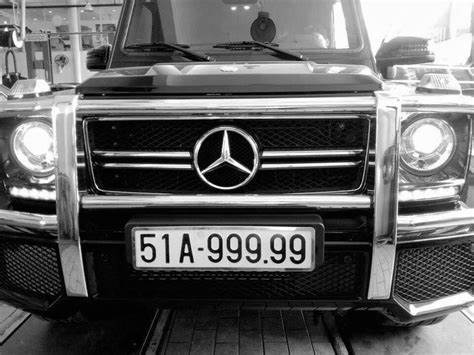

Hinh anh bien so phat hien duoc:


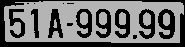

Bien so xe anh thu 1:  51A-999.99




IMG 2


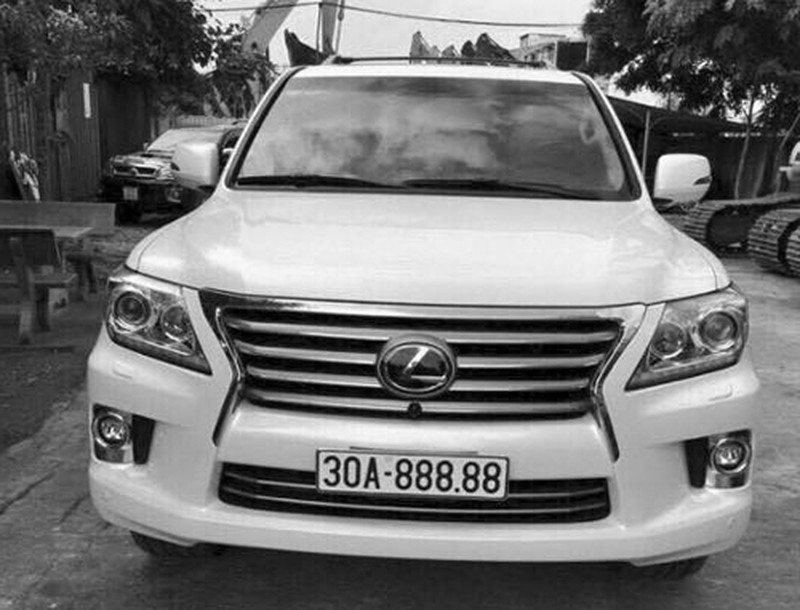

Hinh anh bien so phat hien duoc:


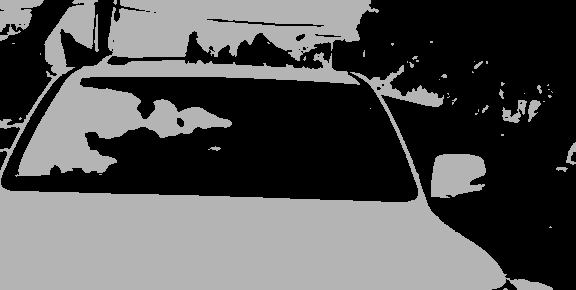

Bien so xe anh thu 2:  T-.




IMG 3


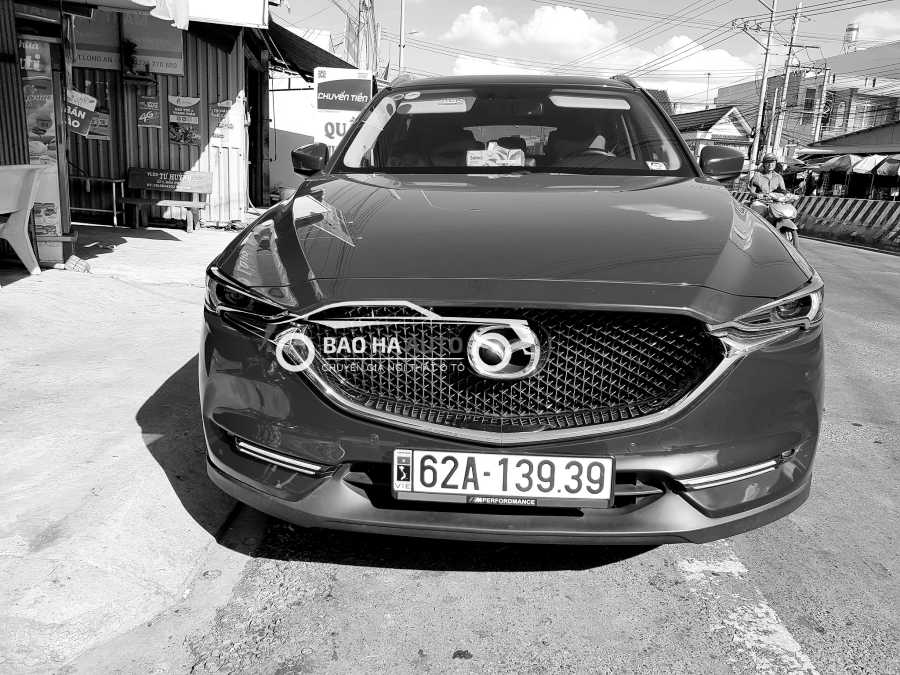

Hinh anh bien so phat hien duoc:


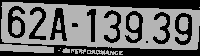

Bien so xe anh thu 3:  62A-13939




IMG 4


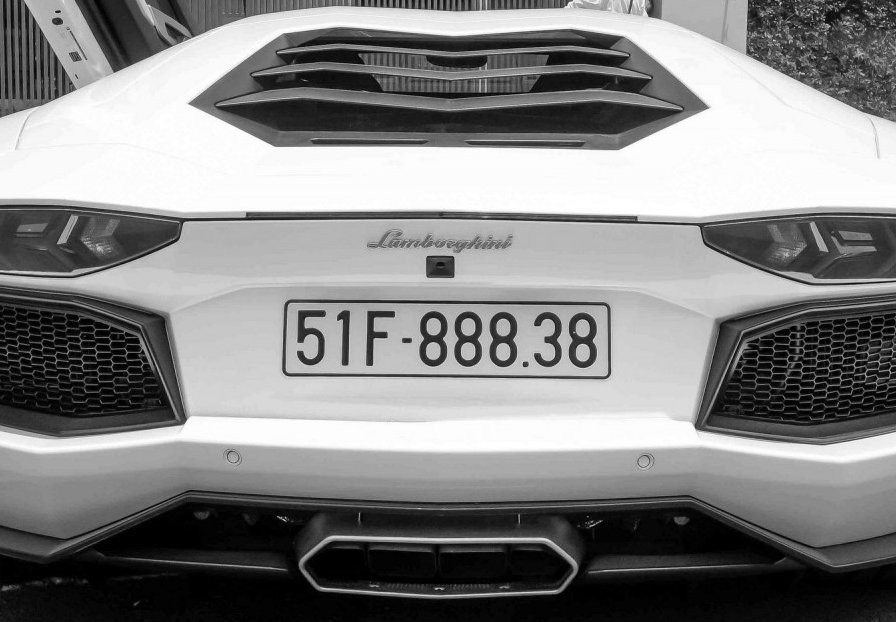

Hinh anh bien so phat hien duoc:


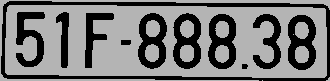

Bien so xe anh thu 4:  51F-88838






In [341]:
s=1
for file in files:
  g_img=cv2.imread(file,0)
  lin=find_lin(img_processing(g_img))
  print("IMG "+str(s))
  cv2_imshow(g_img)
  print("Hinh anh bien so phat hien duoc:")
  cv2_imshow(lin) 
  text=fine_tune(get_string(find_lin(img_processing(g_img))))
  print("Bien so xe anh thu "+str(s)+':  '+str(text))
  s+=1
  print('\n\n\n')
  